In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/daily_total.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.dtypes

DATE            datetime64[ns]
USERCOUNT                int64
SECONDSSPENT             int64
QUANTITY                 int64
VOLUME                 float64
WEIGHT                 float64
PRICE                  float64
dtype: object

In [3]:
df = df[df['DATE'] > '2022-08-10']

In [4]:
codes = dict(zip(df['DATE'].unique(), range(1, len(df['DATE'].unique())+1)))
df['DATE'] = df['DATE'].map(codes)
print(codes)
df

{numpy.datetime64('2022-08-16T00:00:00.000000000'): 1, numpy.datetime64('2022-08-17T00:00:00.000000000'): 2, numpy.datetime64('2022-08-18T00:00:00.000000000'): 3, numpy.datetime64('2022-08-19T00:00:00.000000000'): 4, numpy.datetime64('2022-08-20T00:00:00.000000000'): 5, numpy.datetime64('2022-08-22T00:00:00.000000000'): 6, numpy.datetime64('2022-08-23T00:00:00.000000000'): 7, numpy.datetime64('2022-08-24T00:00:00.000000000'): 8, numpy.datetime64('2022-08-25T00:00:00.000000000'): 9, numpy.datetime64('2022-08-26T00:00:00.000000000'): 10, numpy.datetime64('2022-08-27T00:00:00.000000000'): 11, numpy.datetime64('2022-08-29T00:00:00.000000000'): 12, numpy.datetime64('2022-08-30T00:00:00.000000000'): 13, numpy.datetime64('2022-08-31T00:00:00.000000000'): 14, numpy.datetime64('2022-09-01T00:00:00.000000000'): 15, numpy.datetime64('2022-09-02T00:00:00.000000000'): 16, numpy.datetime64('2022-09-03T00:00:00.000000000'): 17, numpy.datetime64('2022-09-05T00:00:00.000000000'): 18, numpy.datetime64('

,DATE,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
964,1,15,24864,1564,5.510447,606.628000,7714.46
965,2,46,648639,153271,900.823306,87245.837728,731227.04
966,3,72,1535976,353781,2687.981897,247269.820740,2135600.74
967,4,70,1253113,395921,2944.799061,262781.058485,2136707.30
968,5,6,67002,593,14.290446,975.280591,14861.86
...,...,...,...,...,...,...,...
1258,295,101,1171721,854092,2678.434373,292547.191456,1875797.61
1259,296,110,1249771,1016887,3483.392239,371822.547589,2318629.60
1260,297,104,1257222,939123,2998.222002,300263.198492,1850064.42
1261,298,109,1339688,1224169,3863.465093,384720.606181,2390796.27


In [5]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,DATE,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
DATE,1.000000,-0.218943,-0.510317,-0.552823,-0.334129,-0.432707,-0.167726
USERCOUNT,-0.218943,1.000000,0.845610,0.731339,0.683897,0.738980,0.429018
SECONDSSPENT,-0.510317,0.845610,1.000000,0.788504,0.771896,0.837530,0.476098
QUANTITY,-0.552823,0.731339,0.788504,1.000000,0.734363,0.875143,0.368323
VOLUME,-0.334129,0.683897,0.771896,0.734363,1.000000,0.941847,0.555112
WEIGHT,-0.432707,0.738980,0.837530,0.875143,0.941847,1.000000,0.518276
PRICE,-0.167726,0.429018,0.476098,0.368323,0.555112,0.518276,1.000000


In [6]:
# split into train and test sets
cols = ['QUANTITY', 'VOLUME', 'WEIGHT', 'PRICE']

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
train_X, train_y = train[cols], train['SECONDSSPENT']
test_X, test_y = test[cols], test['SECONDSSPENT']

In [7]:
dtrain_reg = xgb.DMatrix(train_X, train_y, enable_categorical=True)
dtest_reg = xgb.DMatrix(test_X, test_y, enable_categorical=True)

In [8]:
params = {"objective": "reg:squarederror", 
          "tree_method": "hist", 
          "learning_rate": 0.001, 
          "max_depth": 1,
          "subsample": 0.8,
          "colsample_bytree": 0.8,
          "seed": 1234, 
          "eval_metric": "mae"}
evals = [(dtrain_reg, "train"), (dtest_reg, "test")]
n = 10000

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   early_stopping_rounds=50
)

[0]	train-mae:1778724.86795	test-mae:1017168.00632
[50]	train-mae:1693733.76780	test-mae:964806.35618
[100]	train-mae:1613631.89314	test-mae:913373.86458
[150]	train-mae:1537444.25667	test-mae:865409.87083
[200]	train-mae:1465275.28360	test-mae:818337.34557
[250]	train-mae:1397228.34401	test-mae:772272.10104
[300]	train-mae:1332125.82741	test-mae:730401.40312
[350]	train-mae:1270498.86140	test-mae:689309.60833
[400]	train-mae:1211656.48130	test-mae:651826.45417
[450]	train-mae:1155943.00968	test-mae:614259.96250
[500]	train-mae:1103132.50092	test-mae:579795.68073
[550]	train-mae:1052925.78347	test-mae:546530.44740
[600]	train-mae:1005004.82976	test-mae:515265.13542
[650]	train-mae:959741.03177	test-mae:486389.31562
[700]	train-mae:916107.69901	test-mae:460315.56250
[750]	train-mae:874954.17050	test-mae:434616.13854
[800]	train-mae:835743.62317	test-mae:411484.41042
[850]	train-mae:798392.41763	test-mae:388439.95104
[900]	train-mae:763264.89644	test-mae:368737.93333
[950]	train-mae:7294

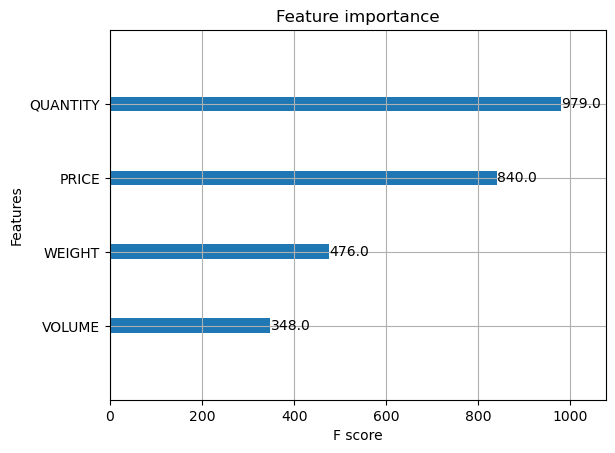

<Figure size 1600x1200 with 0 Axes>

In [9]:
xgb.plot_importance(model)
plt.figure(figsize = (16, 12))
plt.show()

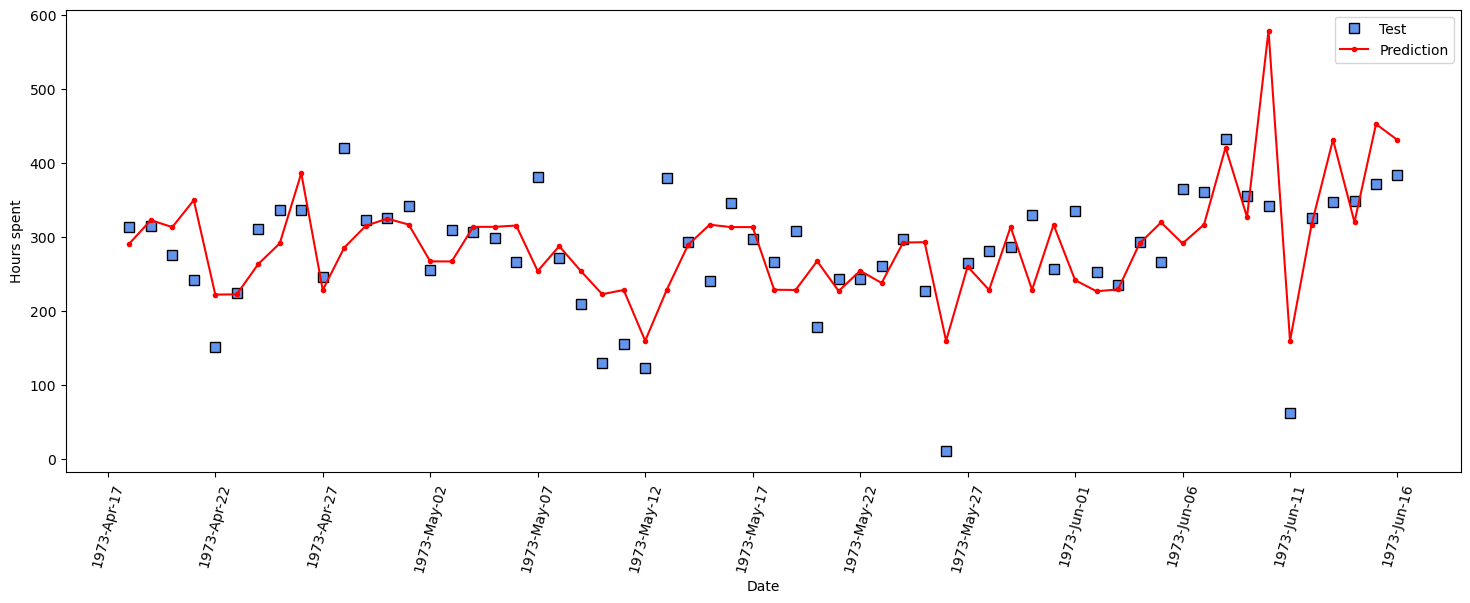

MAE: 50.282


In [10]:
yhat = model.predict(dtest_reg)
date = df.index[train_size:]

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(date, test_y / 3600, 
        linestyle='none', 
        marker='s',
        markerfacecolor='cornflowerblue', 
        markeredgecolor='black',
        markersize=7,
        label='Test')
ax.plot(date, yhat / 3600, 
        linestyle='-',
        marker='o',
        markersize=3,
        color='red',
        label='Prediction')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Hours spent')
plt.xticks(rotation=75)
ax.legend(loc='upper right')
plt.show()

mae = mean_absolute_error(test_y, yhat) / 3600
print('MAE: %.3f' % mae)